# Chandra Random Forest Predictions

In [1]:
import numpy as np
import scipy
import tables
import csv
import datetime as dt
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt
from astropy.time import Time
import itertools as it

%matplotlib inline

In [2]:
chandra = tables.openFile('/Users/bvegetabile/_ucirvine/2015/winter/cs273/finalproject/acq_stats.h5')

In [3]:
allevents = chandra.root.data.read()
allevents.dtype

dtype([('obsid', '<i8'), ('obi', '<i8'), ('acq_start', 'S21'), ('guide_start', 'S21'), ('guide_tstart', '<f8'), ('one_shot_length', '<f8'), ('revision', 'S15'), ('slot', '<i8'), ('idx', '<i8'), ('type', 'S5'), ('yang', '<f8'), ('zang', '<f8'), ('halfw', '<i8'), ('mag', '<f8'), ('acqid', '?'), ('star_tracked', '?'), ('spoiler_tracked', '?'), ('img_func', 'S7'), ('n_trak_interv', '<i8'), ('max_trak_cdy', '<f8'), ('min_trak_cdy', '<f8'), ('mean_trak_cdy', '<f8'), ('max_trak_cdz', '<f8'), ('min_trak_cdz', '<f8'), ('mean_trak_cdz', '<f8'), ('max_trak_mag', '<f8'), ('min_trak_mag', '<f8'), ('mean_trak_mag', '<f8'), ('cdy', '<f8'), ('cdz', '<f8'), ('dy', '<f8'), ('dz', '<f8'), ('ion_rad', '?'), ('def_pix', '?'), ('mult_star', '?'), ('sat_pix', '?'), ('mag_obs', '<f8'), ('yang_obs', '<f8'), ('zang_obs', '<f8'), ('agasc_id', '<i8'), ('color1', '<f8'), ('ra', '<f8'), ('dec', '<f8'), ('epoch', '<f8'), ('pm_ra', '<i8'), ('pm_dec', '<i8'), ('var', '<i8'), ('pos_err', '<i8'), ('mag_aca', '<f8'), ('m

### Description of columns
http://cxc.cfa.harvard.edu/mta/ASPECT/tool_doc/dev/mica/acquisition_data.html

** Columns for Analysis **

_Response Variable_

- acqid: acquisition success indicator (boolean)

_Identifying Variables_

- obsid: the observation identifier for the star catalog
- agasc_id: AGASC (catalog) id of the individual acquisition star

_Input Variables of Interest_

- acq_start: acquisition datestart from kadi event
- mag: catalog MAG_ACA (magnitude of star) of acquisition star
- ra:	AGASC right ascension in degrees
- dec:	AGASC declination in degrees
- n100_warm_frac: estimated n100 fraction of CCD pixels for this observation
- ccd_temp:	mean CCD temperature over 500 seconds surrounding guide transition
- known_bad: (boolean) ignore this star in standard processing

_Creating New Variables_

- dectime: Fractional Time based upon year with fraction of the year
- dayofyear: Day of the year (0-366)

In [4]:
def decimaltime(x):
    return Time(dt.datetime.strptime(x, "%Y:%j:%H:%M:%S.%f"), format='datetime').jyear

def expand_grid(*args, **kwargs):
    columns = []
    lst = []
    if args:
        columns += xrange(len(args))
        lst += args
    if kwargs:
        columns += kwargs.iterkeys()
        lst += kwargs.itervalues()
    return pd.DataFrame(list(it.product(*lst)), columns=columns)

In [5]:
dectime = [decimaltime(x) for x in allevents['acq_start']]
dectime = np.array(dectime)
dayofyear = [dt.datetime.strptime(x, "%Y:%j:%H:%M:%S.%f").strftime('%j') for x in allevents['acq_start']]
dayofyear = np.array(dayofyear).astype('int')
chandraData = pd.DataFrame(allevents[['obsid',
                                      'agasc_id',
                                      'acq_start',
                                      'mag',
                                      'ra',
                                      'dec',
                                      'n100_warm_frac',
                                      'ccd_temp',
                                      'known_bad',
                                      'acqid']])
chandraData['dectime'] = dectime
chandraData['dayofyear'] = dayofyear

### Subsetting Data for Training and Test Subsets

In [6]:
recentData = chandraData[(chandraData['dectime']>=2011.5)]
trainData = chandraData[(chandraData['dectime']>=2011.5) & (chandraData['dectime']<2014.5)]
testData = chandraData[(chandraData['dectime']>=2014.5)]

In [7]:
print """
Number of Training Cases: {0}
Number of Test Cases    : {1}
""".format(trainData.shape[0], testData.shape[0])


Number of Training Cases: 35594
Number of Test Cases    : 6338



## Data Exploration of Recent Data

In [8]:
success = recentData[recentData['acqid']==True]
failed = recentData[recentData['acqid']==False]

#### Warm Pixel Fraction vs. Star Magnitude

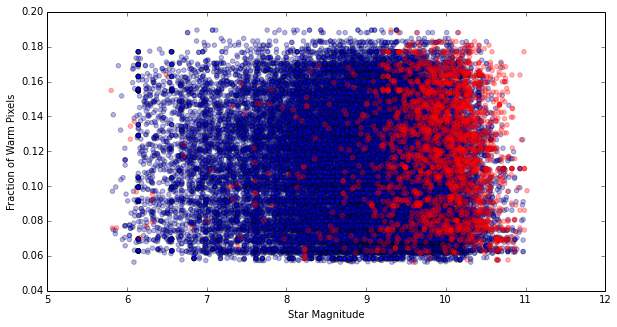

In [9]:
F = plt.figure()
plt.scatter(success['mag'], success['n100_warm_frac'], alpha=0.3)
plt.scatter(failed['mag'], failed['n100_warm_frac'], color='r', alpha=0.3)
plt.xlabel('Star Magnitude')
plt.ylabel('Fraction of Warm Pixels')
F.set_size_inches(10,5)
plt.show()

#### Right Ascension vs. Declination

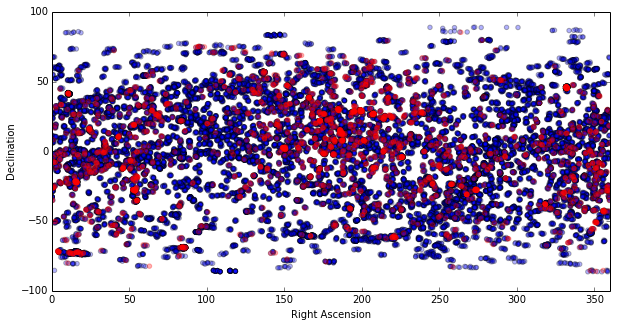

In [10]:
F = plt.figure()
plt.scatter(success['ra'], success['dec'], alpha=0.3)
plt.scatter(failed['ra'], failed['dec'], color='r', alpha=0.3)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.xlim(0, 360)
F.set_size_inches(10,5)
plt.show()

#### Right Ascension vs. Day of Year

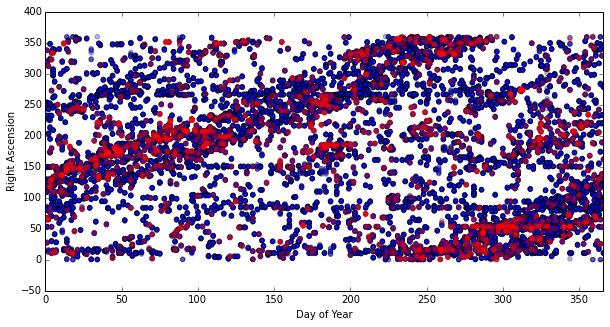

In [11]:
F = plt.figure()
plt.scatter(success['dayofyear'], success['ra'], alpha=0.3)
plt.scatter(failed['dayofyear'], failed['ra'], color='r', alpha=0.3)
plt.ylabel('Right Ascension')
plt.xlabel('Day of Year')
plt.xlim(0, 366)
F.set_size_inches(10,5)
plt.show()

## Random Forests Predictions with Sci-Kit Learn

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
trainData['is_validation'] = np.random.uniform(0, 1, len(trainData)) <= .1
train = trainData[trainData['is_validation']==False]
validate = trainData[trainData['is_validation']==True]
features = trainData.columns[[3,4,5,6,7,11]]
features

Index([u'mag', u'ra', u'dec', u'n100_warm_frac', u'ccd_temp', u'dayofyear'], dtype='object')

### No Min Leaf Settings

In [14]:
nEstimates = np.arange(3,151,3)

mseTrain = np.empty(np.shape(nEstimates)[0])
mseValidate = np.empty(np.shape(nEstimates)[0])

for e, i in enumerate(nEstimates):
    clf = RandomForestClassifier(n_estimators=i)
    y, _ = pd.factorize(train['acqid'])
    y2, _ = pd.factorize(validate['acqid'])

    clf.fit(train[features], y)
    trainPreds = clf.predict_proba(train[features])
    valPreds = clf.predict_proba(validate[features])

    mseTrain[e] = np.sum((y - trainPreds[:,1])**2)/(y.shape[0])
    mseValidate[e] = np.sum((y2 - valPreds[:,1])**2)/(y2.shape[0])


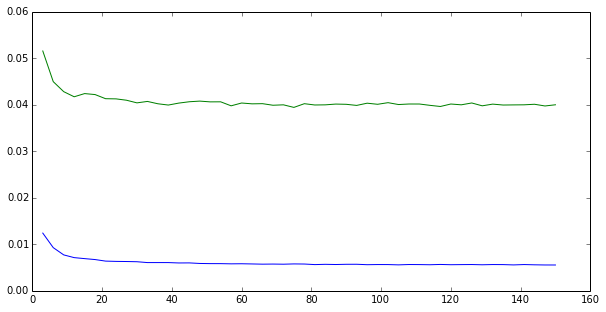

In [15]:
F = plt.figure()
plt.plot(nEstimates,mseTrain)
plt.plot(nEstimates,mseValidate)
F.set_size_inches(10,5)
plt.show()

# How does the model Perform?

In [16]:
clf = RandomForestClassifier(n_estimators=150, criterion='entropy')
yTrain, _ = pd.factorize(trainData['acqid'])
yTest, _ = pd.factorize(testData['acqid'])

clf.fit(trainData[features], yTrain)
trainPreds = clf.predict_proba(trainData[features])
testPreds = clf.predict_proba(testData[features])

mseTrainFinal = np.sum((yTrain - trainPreds[:,1])**2)/(yTrain.shape[0])
mseValidateFinal = np.sum((yTest - testPreds[:,1])**2)/(yTest.shape[0])
mseTrainFailures = np.sum((yTrain[yTrain==1] - trainPreds[yTrain==1,1])**2)/(yTrain[yTrain==1].shape[0])
mseTestFailures = np.sum((yTest[yTest==1] - testPreds[yTest==1,1])**2)/(yTest[yTest==1].shape[0])

In [17]:
print """
Training Dataset MSE: {0} ({2})
Test Dataset MSE    : {1} ({3})
""".format(mseTrainFinal, mseValidateFinal, mseTrainFailures,mseTestFailures)


Training Dataset MSE: 0.00554536782104 (0.0883492448759)
Test Dataset MSE    : 0.0577194838891 (0.60069703543)



### Looking at the how important each feature was to the Random Forest

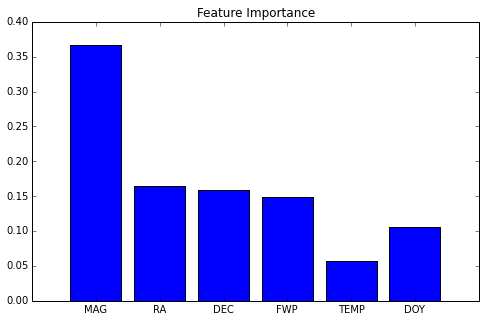

In [18]:
fig, ax = plt.subplots()
ax.bar(np.arange(0.6,6.6),clf.feature_importances_)
ax.set_xticks(np.arange(1,7))
ax.set_xticklabels( ('MAG', 'RA', 'DEC', 'FWP', 'TEMP', 'DOY') )
ax.set_title('Feature Importance')
fig.set_size_inches(8,5)
plt.show()

## Looking at Full Catalog Predictions

### Variable Setup

In [19]:
tf = [True, False]
pick8 = expand_grid(tf,tf,tf,tf,tf,tf,tf,tf)
pick7 = expand_grid(tf,tf,tf,tf,tf,tf,tf)
pick6 = expand_grid(tf,tf,tf,tf,tf,tf)
pick5 = expand_grid(tf,tf,tf,tf,tf)
pick4 = expand_grid(tf,tf,tf,tf)
mask8 = np.sum(pick8, axis=1)
mask7 = np.sum(pick7, axis=1)
mask6 = np.sum(pick6, axis=1)
mask5 = np.sum(pick5, axis=1)
mask4 = np.sum(pick4, axis=1)

### Training Predictions

In [31]:
catalogs = np.unique(trainData['obsid'])
catalogFailures = np.empty(np.shape(catalogs)[0])
trainData['failures'], _ = pd.factorize(trainData['acqid'])
for i, c in enumerate(catalogs):
    catalogFailures[i] = np.sum(trainData[trainData['obsid']==c]['failures'])
catalogs = np.unique(trainData['obsid'])
expectedFails = np.empty(np.shape(catalogs)[0])
for i, c in enumerate(catalogs):
    stars = trainData[trainData['obsid'] == c]
    starPreds = clf.predict_proba(stars[features])
    nstars = np.shape(stars)[0]
    failureProbs = np.empty(nstars+1)
    for p in np.arange(0,nstars+1):
        if nstars == 8:
            prob = np.dot(pick8[mask8==p], np.diag(starPreds[:,1])) + np.dot((1-pick8[mask8==p]), np.diag(starPreds[:,0]))
        if nstars == 7:
            prob = np.dot(pick7[mask7==p], np.diag(starPreds[:,1])) + np.dot((1-pick7[mask7==p]), np.diag(starPreds[:,0]))
        if nstars == 6:
            prob = np.dot(pick6[mask6==p], np.diag(starPreds[:,1])) + np.dot((1-pick6[mask6==p]), np.diag(starPreds[:,0]))
        if nstars == 5:
            prob = np.dot(pick5[mask5==p], np.diag(starPreds[:,1])) + np.dot((1-pick5[mask5==p]), np.diag(starPreds[:,0]))
        if nstars == 4:
            prob = np.dot(pick4[mask4==p], np.diag(starPreds[:,1])) + np.dot((1-pick4[mask4==p]), np.diag(starPreds[:,0]))
        failureProbs[p] = np.sum(np.prod(prob, axis=1))
    exFail = np.dot(np.arange(0,nstars+1),failureProbs)
    expectedFails[i] = exFail

/Users/bvegetabile/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  app.launch_new_instance()


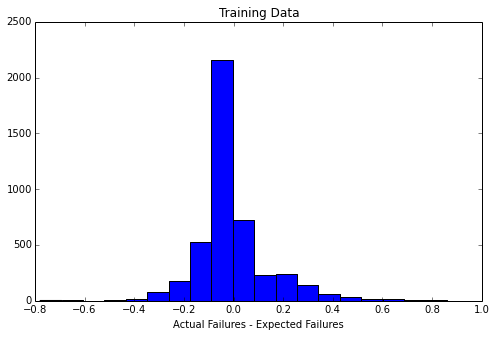

In [32]:
F = plt.figure()
plt.hist(catalogFailures-expectedFails, bins=20)
plt.xlabel('Actual Failures - Expected Failures') 
plt.title('Training Data')
F.set_size_inches(8,5)
plt.show()

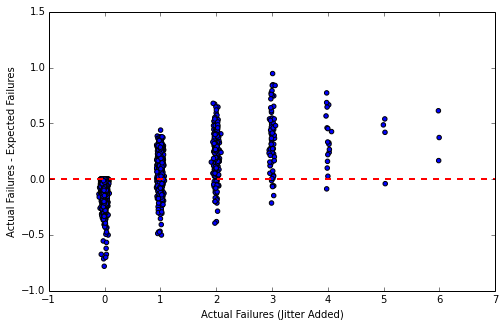

In [33]:
F = plt.figure()
plt.scatter(catalogFailures+ np.random.normal(0,0.025,size=len(catalogFailures)), catalogFailures-expectedFails, )
plt.axhline(y=0, linewidth=2, color = 'r', linestyle='--')
plt.xlabel('Actual Failures (Jitter Added)') 
plt.ylabel('Actual Failures - Expected Failures')
F.set_size_inches(8,5)
plt.show()

### Out of Sample Test Data

In [34]:
catalogs = np.unique(testData['obsid'])
catalogFailures = np.empty(np.shape(catalogs)[0])
testData['failures'], _ = pd.factorize(testData['acqid'])
for i, c in enumerate(catalogs):
    catalogFailures[i] = np.sum(testData[testData['obsid']==c]['failures'])
catalogs = np.unique(testData['obsid'])
expectedFails = np.empty(np.shape(catalogs)[0])
for i, c in enumerate(catalogs):
    stars = testData[testData['obsid'] == c]
    starPreds = clf.predict_proba(stars[features])
    nstars = np.shape(stars)[0]
    failureProbs = np.empty(nstars+1)
    for p in np.arange(0,nstars+1):
        if nstars == 8:
            prob = np.dot(pick8[mask8==p], np.diag(starPreds[:,1])) + np.dot((1-pick8[mask8==p]), np.diag(starPreds[:,0]))
        if nstars == 7:
            prob = np.dot(pick7[mask7==p], np.diag(starPreds[:,1])) + np.dot((1-pick7[mask7==p]), np.diag(starPreds[:,0]))
        if nstars == 6:
            prob = np.dot(pick6[mask6==p], np.diag(starPreds[:,1])) + np.dot((1-pick6[mask6==p]), np.diag(starPreds[:,0]))
        if nstars == 5:
            prob = np.dot(pick5[mask5==p], np.diag(starPreds[:,1])) + np.dot((1-pick5[mask5==p]), np.diag(starPreds[:,0]))
        if nstars == 4:
            prob = np.dot(pick4[mask4==p], np.diag(starPreds[:,1])) + np.dot((1-pick4[mask4==p]), np.diag(starPreds[:,0]))
        failureProbs[p] = np.sum(np.prod(prob, axis=1))
    exFail = np.dot(np.arange(0,nstars+1),failureProbs)
    expectedFails[i] = exFail


/Users/bvegetabile/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  app.launch_new_instance()


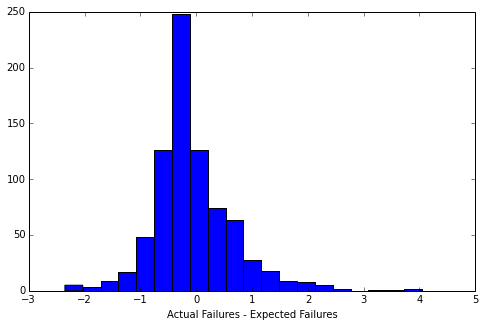

In [35]:
F = plt.figure()
plt.hist(catalogFailures-expectedFails, bins=20)
plt.xlabel('Actual Failures - Expected Failures') 
F.set_size_inches(8,5)
plt.show()

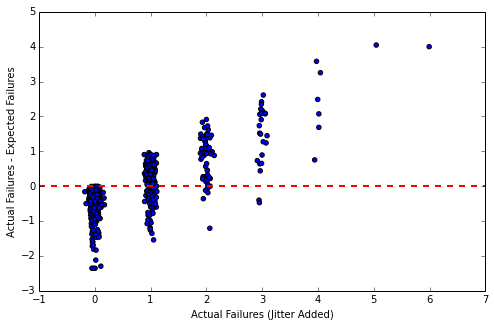

In [36]:
F = plt.figure()
plt.scatter(catalogFailures+ np.random.normal(0,0.05,size=len(catalogFailures)), catalogFailures-expectedFails, )
plt.axhline(y=0, linewidth=2, color = 'r', linestyle='--')
plt.xlabel('Actual Failures (Jitter Added)') 
plt.ylabel('Actual Failures - Expected Failures')
F.set_size_inches(8,5)
plt.show()